# Simple Harmonic Oscillator

## Learning Objectives

In this notebook, you will:
1. Understand the physics of a **simple harmonic oscillator** using Lagrangian mechanics
2. Build a standard neural network to fit oscillatory data
3. Learn why vanilla NNs fail to generalize with sparse data
4. Implement a **Physics-Informed Neural Network (PINN)** that embeds physical laws into the loss function
5. See how physics constraints enable extrapolation beyond training data

## Import libraries

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from PIL import Image

# Ensure plots directory exists
os.makedirs("../plots", exist_ok=True)

## The physics

### What is a Lagrangian?

The **Lagrangian** $L$ is a fundamental concept in classical mechanics that encapsulates the dynamics of a physical system. It is defined as the difference between kinetic energy $T$ and potential energy $V$:

\begin{equation}
L = T - V
\end{equation}

For a simple harmonic oscillator (like a mass on a spring), we have:
- **Kinetic energy**: $T = \frac{1}{2} m\left(\frac{dx}{dt}\right)^2$ — energy from motion
- **Potential energy**: $V = \frac{1}{2} kx^2$ — energy stored in the spring

Thus, the Lagrangian for a simple harmonic oscillator is:

\begin{equation}
L = \frac{1}{2} m\left(\frac{dx}{dt}\right)^2 - \frac{1}{2} kx^2
\end{equation}

### Why use the Lagrangian?

The power of the Lagrangian formulation is that the equations of motion can be derived systematically using the **Euler-Lagrange equation**:

\begin{equation}
\frac{d}{dt}\left(\frac{\partial L}{\partial \dot{x}}\right) - \frac{\partial L}{\partial x} = 0
\end{equation}

Applying this to our Lagrangian:
1. $\frac{\partial L}{\partial \dot{x}} = m\dot{x}$ → $\frac{d}{dt}(m\dot{x}) = m\ddot{x}$
2. $\frac{\partial L}{\partial x} = -kx$

This gives us the equation of motion:

\begin{equation}
m \frac{d^2x}{dt^2} = -kx
\end{equation}

This is the familiar **Hooke's Law** combined with **Newton's second law**: the restoring force is proportional to displacement and opposes it.

## Solving analytically

### The Exact Solution

The general solution to the SHO differential equation is:

\begin{equation}
x(t) = A \cos(\omega t + \phi)
\end{equation}

where:
- $A$ is the **amplitude** (maximum displacement)
- $\omega = \sqrt{\frac{k}{m}}$ is the **angular frequency** (how fast it oscillates)
- $\phi$ is the **phase** (where in the cycle we start)

**Why cosine?** The second derivative of $\cos(\omega t)$ is $-\omega^2 \cos(\omega t)$, which perfectly satisfies our equation when $\omega^2 = k/m$.

Let's visualize this solution with some example parameters:

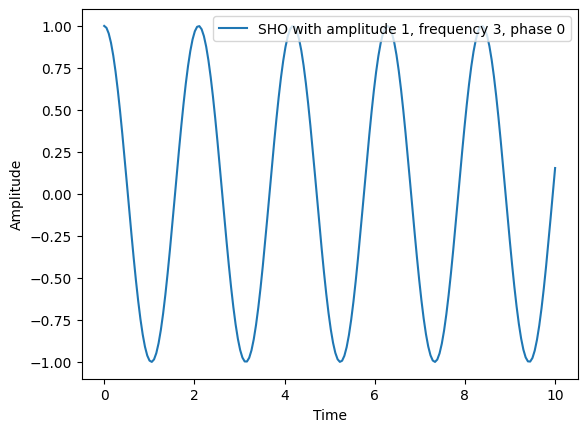

In [2]:
# Example parameters
example_amplitude = 1
example_phase = 0
example_frequency = 3

example_times = np.linspace(0, 10, 200)  # Example input


def sho(amplitude, frequency, phase, time):
    return amplitude * np.cos(frequency * time + phase)


shos = sho(example_amplitude, example_frequency, example_phase, example_times)
plt.plot(example_times, shos)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend([f"SHO with amplitude {example_amplitude}, frequency {example_frequency}, phase {example_phase}"], loc="upper right")
plt.show()

## Solving with a NN

Lets try to fit a standard Neural network to some training data we get from our solution.

### Step 1: Create some training data from the known analytic solution

In [3]:
# Select some physics parameters
amplitude = 1
frequency = 30
phase = 0

# Create synethtic data
time = torch.linspace(0, 1, 200).view(-1, 1)
sho_analytic_solution = sho(amplitude, frequency, phase, time).view(-1, 1)

# Create a subsample of the data for training
time_samples = time[0:50:5]
sho_samples = sho_analytic_solution[0:50:5]

/var/folders/5d/bxtgt7mx0t96v3hcy5pf510c0000gn/T/ipykernel_27088/3804987893.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return amplitude * np.cos(frequency * time + phase)


### Step 2: Create a standard Feed Forward Fully Connected Nueral network

### Neural Network Architecture Design

Now let's design a neural network to approximate the SHO solution. Here are our key design choices:

**Architecture: Fully Connected (Feed-Forward) Network**
- **Input layer**: 1 neuron (time $t$)
- **Hidden layers**: Multiple layers with many neurons
- **Output layer**: 1 neuron (position $x$)

**Why this structure?**
- We're learning a function $x(t)$: one input → one output
- Hidden layers allow the network to learn complex, non-linear mappings
- More layers and neurons = more capacity to represent oscillatory behavior

**Activation Function: Tanh**

We use $\tanh$ for several important reasons:
1. **Smoothness**: $\tanh$ is infinitely differentiable, which is crucial because we'll compute $\frac{dx}{dt}$ and $\frac{d^2x}{dt^2}$ through the network
2. **Bounded output**: $\tanh$ outputs values in $[-1, 1]$, similar to our oscillator's bounded motion
3. **Zero-centered**: Unlike ReLU, $\tanh$ can naturally represent both positive and negative values

**Note**: ReLU would be problematic here because its second derivative is zero everywhere (except at the kink), making it impossible to satisfy our physics equation!

In [4]:
class shoNN(torch.nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        # TODO: Define the input layer, hidden layers, and output layer.
        # The input layer should be a linear layer followed by an activation function.
        # The hidden layers should be a sequence of linear layers followed by activation functions.
        # The output layer should be a linear layer.

        # SOLUTION START
        self.input_layer = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation())
        self.hidden_layers = nn.Sequential(*[nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation()) for _ in range(N_LAYERS - 1)])
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)
        # SOLUTION END

    def forward(self, x):
        # TODO: Implement the forward pass.
        # The input should pass through the input layer, the hidden layers, and the output layer in order.

        # SOLUTION START
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x
        # SOLUTION END

In [5]:
# Test the shoNN class
test_model = shoNN(1, 1, 20, 2)

# Set the weights of the model for testing
with torch.no_grad():
    for param in test_model.parameters():
        param.fill_(0.5)

assert isinstance(test_model, torch.nn.Module), "The shoNN class should inherit from torch.nn.Module."
assert hasattr(test_model, "forward"), "The shoNN class should have a 'forward' method."

# Test a forward pass
input_data = torch.tensor([[0.0], [0.1], [0.2], [0.3]])
output_data = test_model(input_data)

assert output_data.shape == (4, 1), "The output shape is incorrect."

# Expected output
expected_output = torch.tensor([[10.499288], [10.499669], [10.499841], [10.499922]])

assert torch.allclose(output_data, expected_output, atol=1e-6), "The output values are not as expected."

Before training the NN, lets visualise what we are about to do. The graph below shows the analytic solution in blue, which is an exact solution to the differential equation for a SHO. We have then sampled a subset of the solutions to the equation at specific times to create a training 'y' variable, and will be fed to the NN for training. 

Note that the training data onll covers a small subset of the full range of 'x' values. This is important as it highlights that we are not going to simply fit the NN to the functional data, rather a subset of the data and 'learn' the rest of the solution by providing it 'physical insight' directly into the loss function.

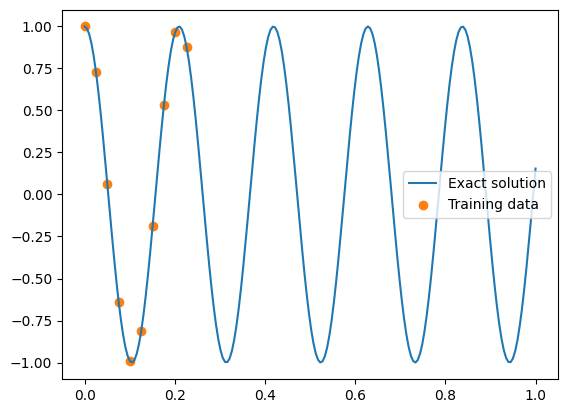

In [6]:
plt.figure()
plt.plot(time, sho_analytic_solution, label="Exact solution")
plt.scatter(time_samples, sho_samples, color="tab:orange", label="Training data")
plt.legend()
plt.show()

### Step 3: Create some plotting functions for easy visualisation

In [7]:
def plot_result(x, y, x_data, y_data, yh, xp=None, step=None):
    """Pretty plot training results.

    Args:
        x: Time values for exact solution
        y: Exact solution values
        x_data: Training data time values
        y_data: Training data values
        yh: Neural network prediction
        xp: Physics loss training locations (optional)
        step: Training step number for display (optional)
    """
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x, yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label="Training data")
    if xp is not None:
        plt.scatter(xp, -0 * torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, label="Physics loss training locations")
    legend = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(legend.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    if step is not None:
        plt.text(1.065, 0.7, f"Training step: {step}", fontsize="xx-large", color="k")
    plt.axis("off")


def save_gif_PIL(outfile, files, fps=5, loop=0):
    """Save a list of image files as an animated GIF."""
    images = [Image.open(fn) for fn in files]
    images[0].save(outfile, save_all=True, append_images=images[1:], optimize=False, duration=1000 / fps, loop=loop)

### Step 4: Train the NN on training data with a normal MSE loss

### What is MSE Loss?

**Mean Squared Error (MSE)** measures how far our predictions are from the true values:

\begin{equation}
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i)^2
\end{equation}

where $\hat{y}_i$ is the predicted value and $y_i$ is the target value.

**Why squared error?**
- Penalizes larger errors more heavily (quadratic penalty)
- Always positive (no cancellation between positive and negative errors)
- Differentiable everywhere (important for gradient descent)

At this point, we're training a **vanilla neural network** — just fitting to data points with no physics knowledge.

In [8]:
def simple_mse_loss(predicted: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """Compute mean squared error between predicted and target values.

    Note that at this point, we are not including the physics loss.

    Args:
        predicted: Predicted values from the model
        target: Target values from training data

    Returns:
        Mean squared error loss
    """
    # TODO: Implement the mean squared error loss function

    # SOLUTION START
    predicted = predicted.squeeze()
    target = target.squeeze()
    loss = torch.mean((predicted - target) ** 2)
    return loss
    # SOLUTION END


assert simple_mse_loss(torch.tensor([[1.0], [2.0], [3.0]]), torch.tensor([[1.0], [2.0], [3.0]])).item() == 0.0, "The loss is not correct."
assert torch.allclose(simple_mse_loss(torch.tensor([[1.0], [2.0], [3.0]]), torch.tensor([[1.1], [2.1], [3.1]])).detach(), torch.tensor(0.01)), (
    "The loss is not correct."
)

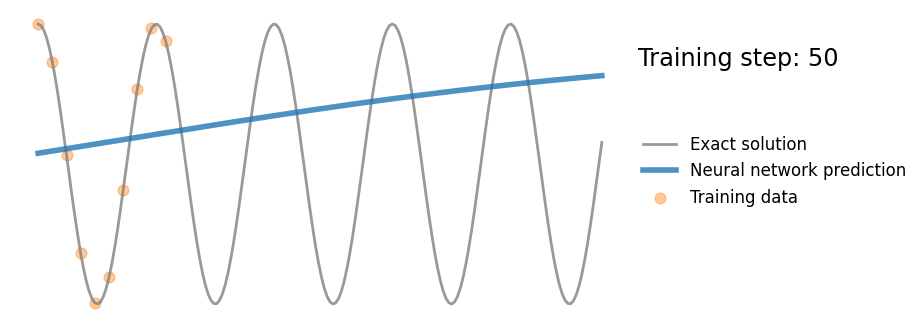

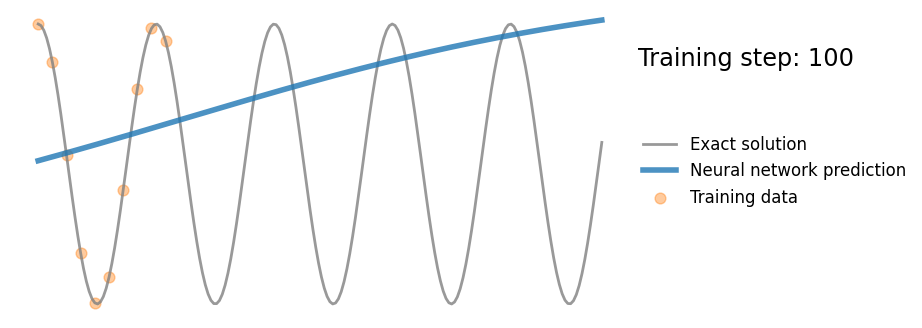

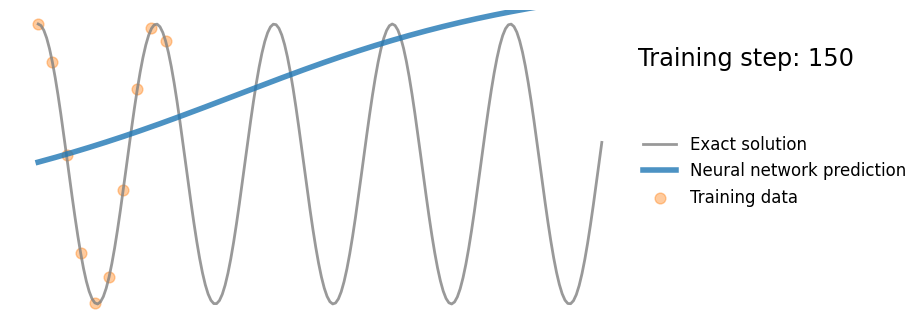

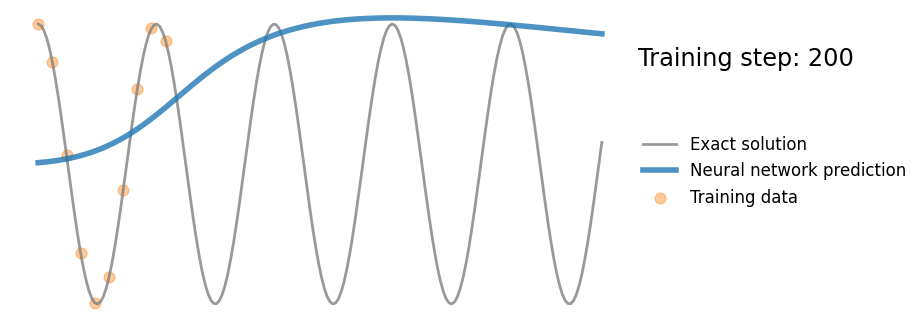

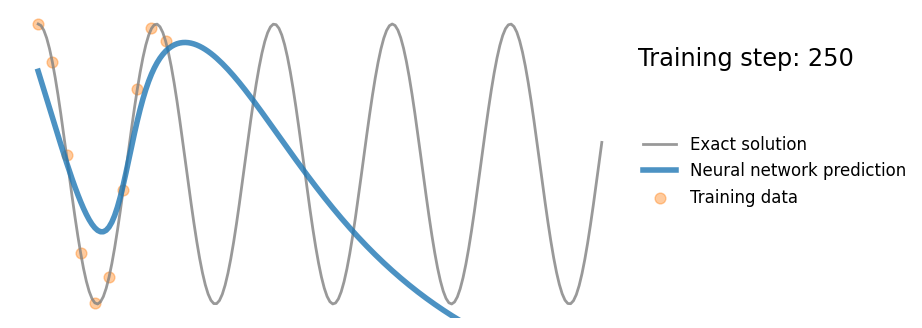

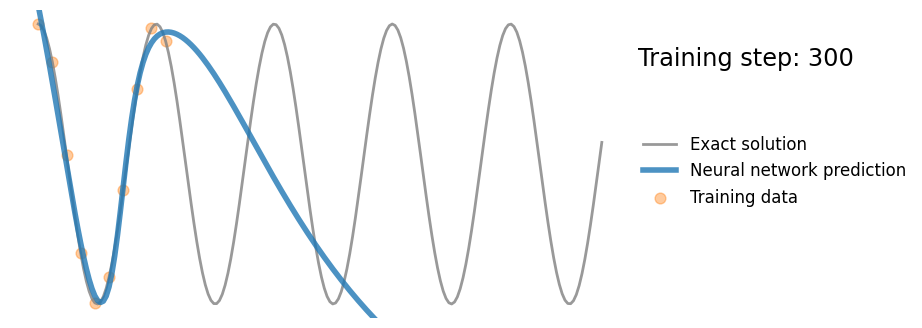

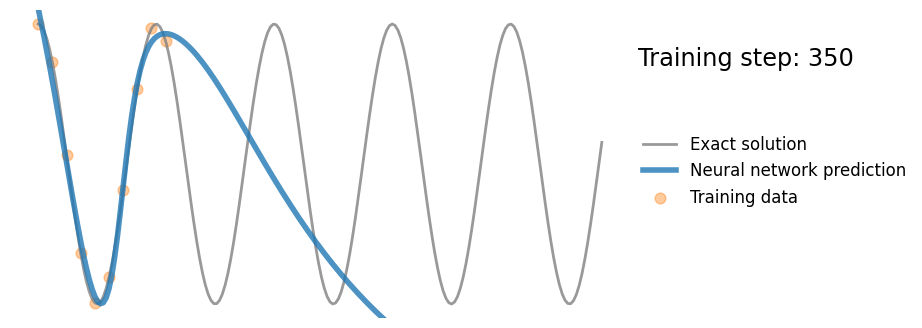

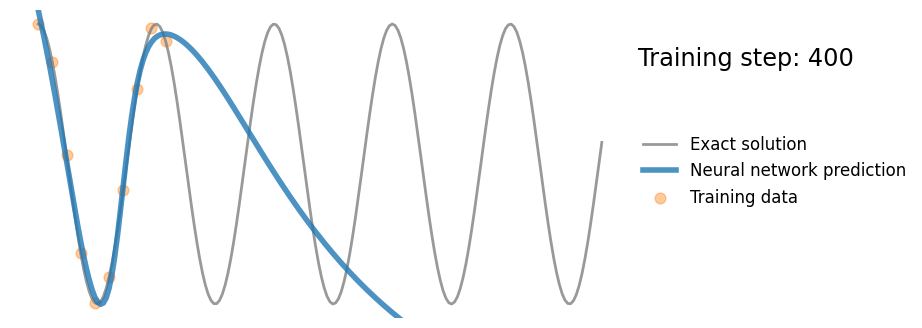

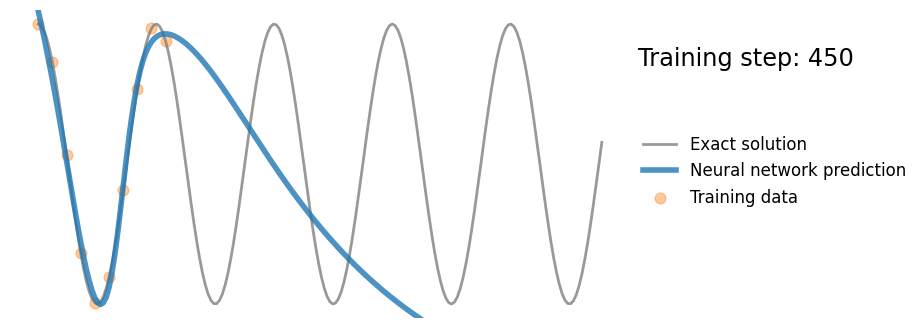

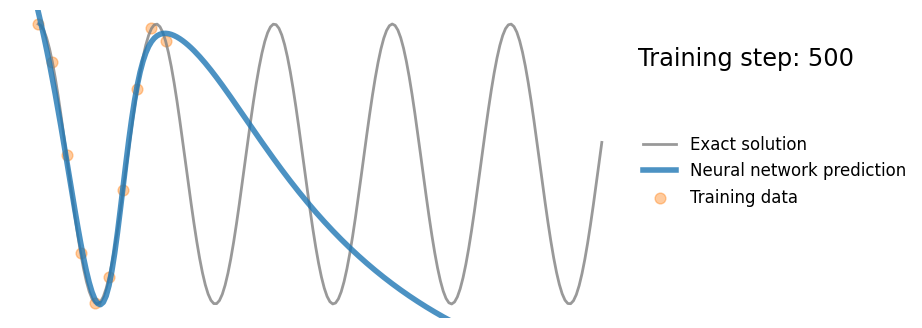

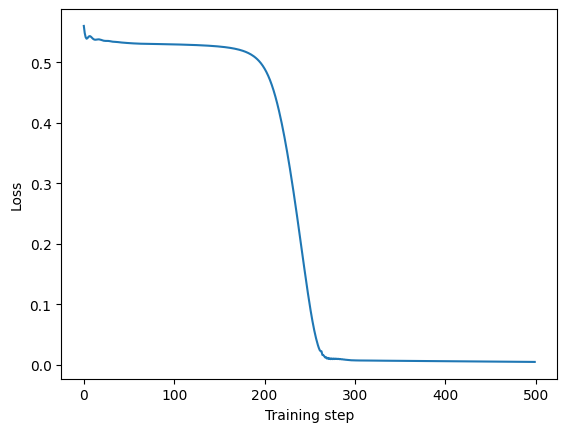

In [17]:
# Train standard neural network to fit training data
torch.manual_seed(123)

# Instantiate the model that has one input (time) and one output (the amplitude of the SHO)
model = shoNN(1, 1, 32, 3)
assert isinstance(model, torch.nn.Module), "model should be an instance of torch.nn.Module"
assert model.input_layer[0].in_features == 1, "The input dimension of the model should be 1."
assert model.output_layer.out_features == 1, "The output dimension of the model should be 1."

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []
losses = []
for i in range(500):
    optimizer.zero_grad()
    sho_predicted = model(time_samples)
    loss = simple_mse_loss(predicted=sho_predicted, target=sho_samples)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    # Plot the result as training progresses
    if (i + 1) % 10 == 0:
        sho_predicted_plot = model(time).detach()
        plot_result(time, sho_analytic_solution, time_samples, sho_samples, sho_predicted_plot, step=i + 1)

        file = f"../plots/nn_{i + 1:08d}.png"
        plt.savefig(file, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i + 1) % 50 == 0:
            plt.show()
        else:
            plt.close("all")

plt.plot(losses)
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.show()
save_gif_PIL("nn_nosholoss.gif", files, fps=10, loop=0)

### Reflection: Why the Vanilla NN Failed

Let's reflect on these results:

1. **Perfect fit on training data**: The NN fits the training points exactly, which isn't surprising — it has more parameters than data points. The system is **completely overfit**.

2. **No generalization**: The loss plateaus quickly, but the model fails catastrophically on unseen data (outside the training region).

3. **The fundamental problem**: A standard NN has no knowledge that the underlying function should be oscillatory. It just interpolates between points and extrapolates poorly.

**Key insight**: With sparse data, a neural network needs additional constraints (like physics) to generalize beyond the training distribution.

### Step 5: Train the NN with SHO and boundary term loss

### Physics-Informed Loss Functions

The key insight of **Physics-Informed Neural Networks (PINNs)** is to embed physical laws directly into the loss function. We add two physics-based terms:

#### 1. Differential Equation Loss (SHO Loss)

This term enforces that the neural network output satisfies the equation of motion at sampled points:

\begin{equation}
L_{\text{SHO}} = \frac{1}{N} \sum_{i=1}^{N} \left(\frac{d^2x}{dt^2} + \omega^2 x \right)^2
\end{equation}

**Interpretation**: If the network truly represents a harmonic oscillator, then $\ddot{x} + \omega^2 x = 0$ everywhere. Any deviation from zero is penalized.

**How do we compute $\frac{d^2x}{dt^2}$?** Using **automatic differentiation** (PyTorch's `autograd`), we can differentiate through the neural network to get exact derivatives — no finite differences needed!

#### 2. Boundary/Initial Condition Loss

This term ensures the solution starts with the correct initial conditions:

\begin{equation}
L_{\text{boundary}} = (x(0) - 1)^2 + \left( \frac{dx}{dt}(0) - 0 \right)^2
\end{equation}

**Interpretation**: 
- $x(0) = 1$: The oscillator starts at position 1 (maximum displacement)
- $\dot{x}(0) = 0$: The oscillator starts at rest (zero velocity)

These conditions uniquely specify a cosine solution with amplitude 1 and phase 0.

### Computing Derivatives Through the Network

To evaluate the physics loss, we need to compute derivatives of the network output with respect to its input (time). PyTorch's **automatic differentiation** makes this straightforward:

```python
torch.autograd.grad(output, input, grad_outputs=..., create_graph=True)
```

Key parameters:
- `create_graph=True`: Allows us to differentiate again (needed for second derivative)
- `grad_outputs`: Specifies which outputs to differentiate (typically `torch.ones_like(output)`)

This is much more accurate than finite differences and works seamlessly with backpropagation for training.

In [10]:
def compute_model_and_derivatives(model, time_vector):
    """Compute the model outputs and first/second derivatives with respect to time.

    Use the torch.autograd.grad function to compute the derivatives of the
    model output with respect to time_vector.

    Args:
        model: The neural network model.
        time_vector: The input time values to the model.

    Returns:
        Tuple of (model_outputs, first_derivative, second_derivative)
    """
    # TODO: Implement the derivative computation using torch.autograd.grad

    # SOLUTION START
    time_vector.requires_grad = True
    model_outputs = model(time_vector)
    first_derivative = torch.autograd.grad(model_outputs, time_vector, torch.ones_like(model_outputs), create_graph=True)[0]
    second_derivative = torch.autograd.grad(first_derivative, time_vector, torch.ones_like(first_derivative), create_graph=True)[0]
    return model_outputs, first_derivative, second_derivative
    # SOLUTION END

In [11]:
# Test the compute_model_and_derivatives function
torch.manual_seed(123)
model = shoNN(1, 1, 32, 3)
time_vector = torch.linspace(0, 1, steps=10).view(-1, 1).requires_grad_(True)
model_outputs, first_derivative, second_derivative = compute_model_and_derivatives(model, time_vector)

# Check the shapes of the outputs
assert model_outputs.shape == time_vector.shape, "The shape of model_outputs is not correct."
assert first_derivative.shape == time_vector.shape, "The shape of first_derivative is not correct."
assert second_derivative.shape == time_vector.shape, "The shape of second_derivative is not correct."

# Check the types of the outputs
assert isinstance(model_outputs, torch.Tensor), "model_outputs should be a torch.Tensor."
assert isinstance(first_derivative, torch.Tensor), "first_derivative should be a torch.Tensor."
assert isinstance(second_derivative, torch.Tensor), "second_derivative should be a torch.Tensor."

# Check the values of the outputs
assert torch.allclose(model_outputs, model(time_vector)), "model_outputs should be the output of the model."
assert torch.allclose(first_derivative, torch.autograd.grad(model_outputs, time_vector, torch.ones_like(model_outputs), create_graph=True)[0]), (
    "first_derivative should be the first derivative of the model outputs."
)
assert torch.allclose(
    second_derivative, torch.autograd.grad(first_derivative, time_vector, torch.ones_like(first_derivative), create_graph=True)[0]
), "second_derivative should be the second derivative of the model outputs."

### Understanding the Physics Loss Function

The `physics_loss` function implements $L_{\text{SHO}} = \text{mean}\left[\left(\ddot{x} + \omega^2 x\right)^2\right]$.

This is the **residual** of our differential equation — if the network perfectly represents an SHO solution, this residual is zero everywhere.

**Why does this work?**
- The network is forced to not just fit data points, but to satisfy the underlying physics between data points
- This acts as a strong **regularizer** that prevents overfitting and enables extrapolation

In [12]:
def physics_loss(amplitude, first_derivative, second_derivative, frequency):
    """Compute the physics loss enforcing the SHO differential equation.

    The physics loss is the mean squared residual of the SHO equation:
    d²x/dt² + ω²x = 0

    Args:
        amplitude: The amplitude of the SHO, x(t)
        first_derivative: The first derivative, dx/dt (unused but kept for consistency)
        second_derivative: The second derivative, d²x/dt²
        frequency: The angular frequency of the SHO (omega)

    Returns:
        Mean squared residual of the differential equation
    """
    # TODO: Implement the physics loss based on the SHO equation of motion

    # SOLUTION START
    diff_eq = second_derivative + frequency**2 * amplitude
    loss = torch.mean(diff_eq**2)
    return loss
    # SOLUTION END

In [13]:
# Test case 1: When amplitude, first_derivative, second_derivative, and frequency are all zeros
amplitude = torch.tensor([0.0])
first_derivative = torch.tensor([0.0])
second_derivative = torch.tensor([0.0])
frequency = torch.tensor([0.0])
expected_output = torch.tensor([0.0])
assert physics_loss(amplitude, first_derivative, second_derivative, frequency) == expected_output

# Test case 2: When amplitude, first_derivative, second_derivative, and frequency are all ones
amplitude = torch.tensor([1.0])
first_derivative = torch.tensor([1.0])
second_derivative = torch.tensor([1.0])
frequency = torch.tensor([1.0])
expected_output = torch.tensor([4.0])
assert physics_loss(amplitude, first_derivative, second_derivative, frequency) == expected_output

In [14]:
def compute_initial_condition_loss(predicted_amplitude, predicted_first_derivative, expected_amplitude=1, expected_first_derivative=0):
    """Compute the loss for initial conditions.

    We want the initial position (t=0) to have an amplitude of 1 and the initial velocity to be 0.

    Args:
        predicted_amplitude: The predicted amplitude of the SHO at t=0.
        predicted_first_derivative: The predicted first derivative of the amplitude at t=0.
        expected_amplitude: The expected amplitude at t=0.
        expected_first_derivative: The expected first derivative at t=0.

    Returns:
        Sum of squared errors for initial conditions
    """
    # TODO: Implement the initial condition loss

    # SOLUTION START
    initial_amplitude_loss = (predicted_amplitude - expected_amplitude) ** 2
    initial_velocity_loss = (predicted_first_derivative - expected_first_derivative) ** 2
    loss = initial_amplitude_loss + initial_velocity_loss
    return loss
    # SOLUTION END

In [15]:
# Test when predicted values match the expected values
assert compute_initial_condition_loss(1, 0) == 0, "Test failed: Expected loss is 0 when predicted values match the expected values"

# Test when predicted values do not match the expected values
assert compute_initial_condition_loss(2, 1) == 2, "Test failed: Expected loss is 2 when predicted values do not match the expected values"

# Test when expected values are different from the default values
assert compute_initial_condition_loss(2, 1, 2, 1) == 0, "Test failed: Expected loss is 0 when predicted values match the non-default expected values"

# Test with negative values
assert compute_initial_condition_loss(-1, -1) == 5, "Test failed: Expected loss is 5 when predicted values are negative"

# Test with floating point values
assert compute_initial_condition_loss(1.5, 0.5) == 0.5, "Test failed: Expected loss is 0.5 when predicted values are floating point numbers"

### Training with Combined Losses

Now we combine three loss terms:

\begin{equation}
L_{\text{total}} = L_{\text{data}} + \lambda_1 \cdot L_{\text{SHO}} + \lambda_2 \cdot L_{\text{boundary}}
\end{equation}

| Loss | Formula | Purpose |
|------|---------|---------|
| $L_{\text{data}}$ | $\text{mean}[(x_{\text{pred}} - x_{\text{train}})^2]$ | Fit training data |
| $L_{\text{SHO}}$ | $\text{mean}[(\ddot{x} + \omega^2 x)^2]$ | Satisfy differential equation |
| $L_{\text{boundary}}$ | $(x(0) - 1)^2 + (\dot{x}(0))^2$ | Correct initial conditions |

**The hyperparameters** $\lambda_1$ and $\lambda_2$ control the balance between fitting data and satisfying physics. Finding the right balance often requires experimentation.

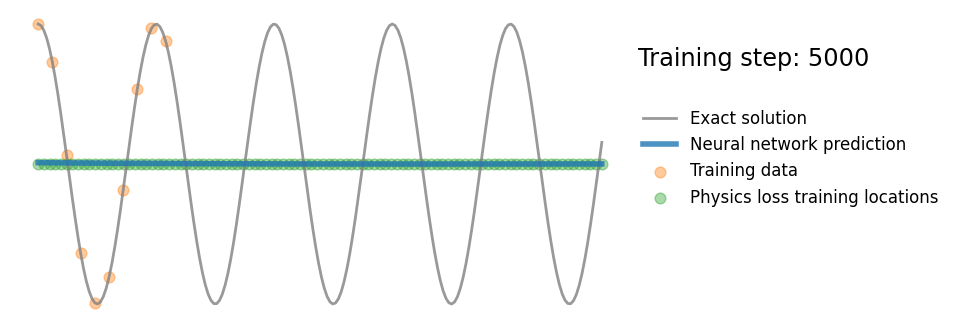

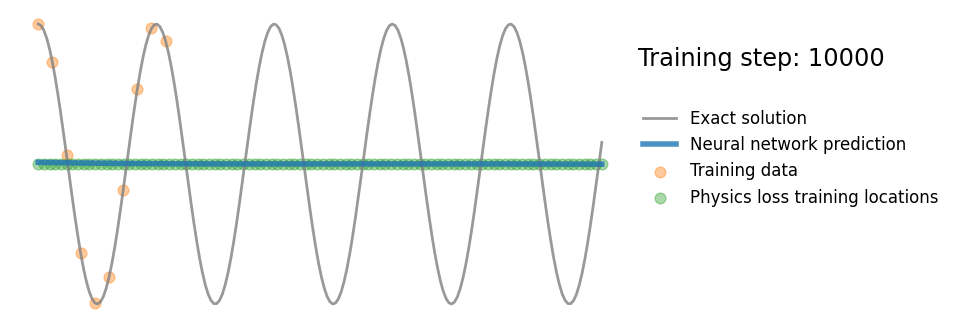

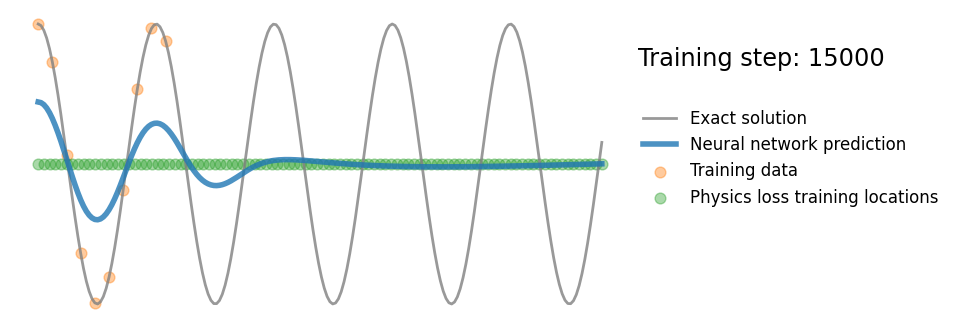

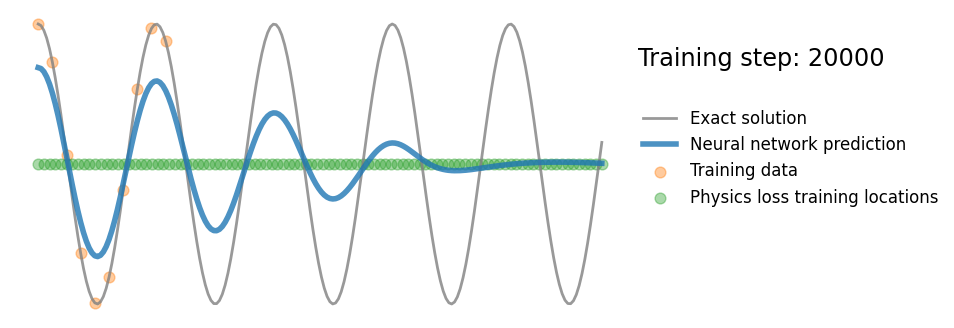

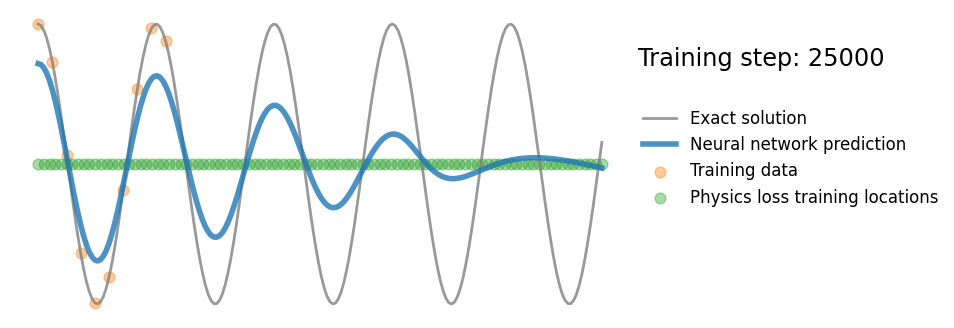

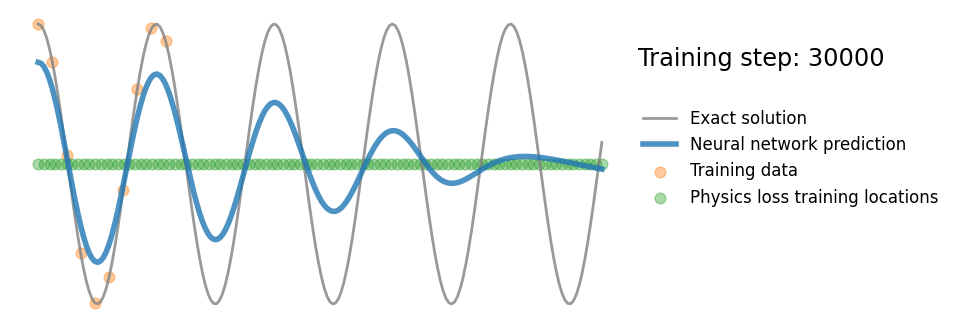

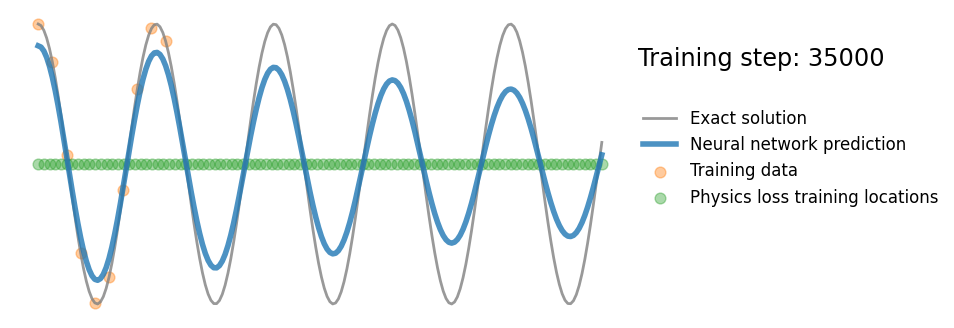

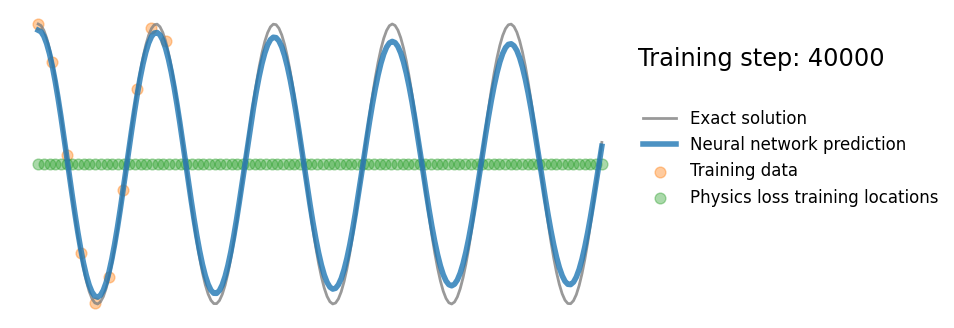

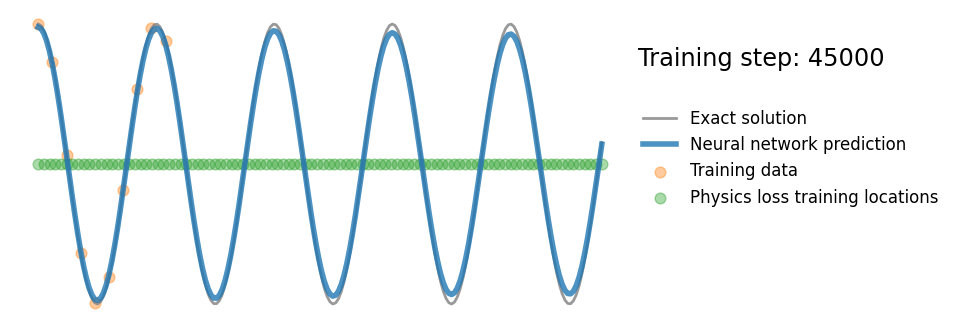

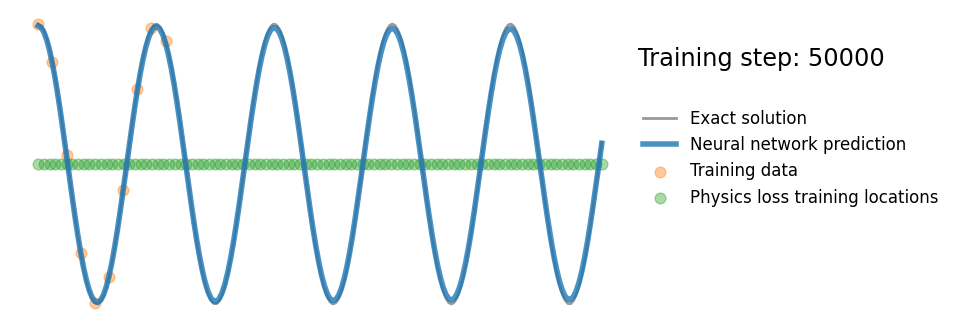

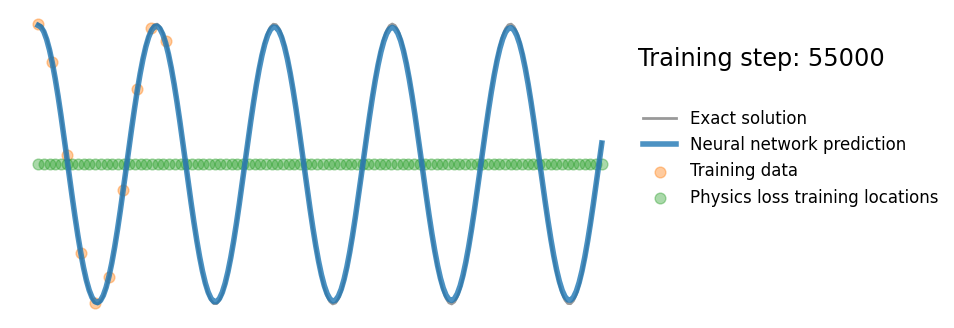

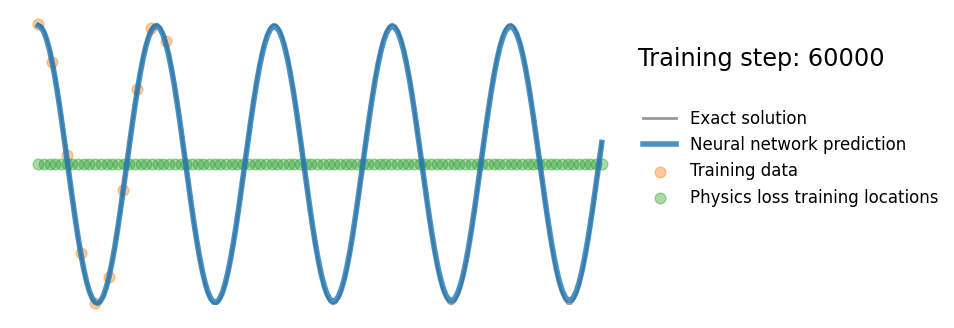

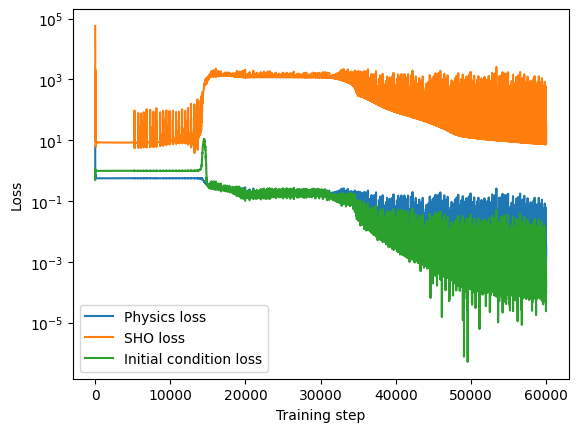

In [16]:
# Generate time values for physics loss evaluation
time_physics = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True)

# Initial time = 0 for initial conditions: x(0)=1, dx/dt(0)=0
initial_time = torch.tensor(0.0).view(-1, 1).requires_grad_(True)

torch.manual_seed(1)
model = shoNN(1, 1, 32, 3)
files = []
sho_loss_weight = 1e-4
initial_condition_loss_weight = 1e-4
frequency = 30

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

losses_physics = []
losses_sho = []
losses_initial_condition = []

for i in range(60000):
    optimizer.zero_grad()
    sho_predicted = model(time_samples)
    loss1 = torch.mean((sho_predicted - sho_samples) ** 2)  # MSE loss

    # Compute the physics loss (not on the boundary or initial condition)
    sho_predicted_physics, dtsho_predicted_physics, d2tsho_predicted_physics = compute_model_and_derivatives(model, time_physics)
    sho_loss = physics_loss(sho_predicted_physics, dtsho_predicted_physics, d2tsho_predicted_physics, frequency)

    # Compute the initial condition loss
    initial_sho_x, initial_sho_dt, initial_sho_d2t = compute_model_and_derivatives(model, initial_time)
    initial_condition_loss = compute_initial_condition_loss(initial_sho_x, initial_sho_dt)

    loss = loss1 + sho_loss_weight * sho_loss + initial_condition_loss_weight * initial_condition_loss
    loss.backward()
    optimizer.step()
    losses_sho.append(sho_loss.item())
    losses_initial_condition.append(initial_condition_loss.item())
    losses_physics.append(loss.item())

    if (i + 1) % 200 == 0:
        sho_predicted = model(time).detach()
        time_p = time_physics.detach()

        plot_result(time, sho_analytic_solution, time_samples, sho_samples, sho_predicted, time_p, step=i + 1)
        file = f"../plots/nn_physics_{i + 1:08d}.png"
        plt.savefig(file, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i + 1) % 5000 == 0:
            plt.show()
        else:
            plt.close("all")

plt.plot(losses_physics, label="Physics loss")
plt.plot(losses_sho, label="SHO loss")
plt.plot(losses_initial_condition, label="Initial condition loss")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()

save_gif_PIL("physics_nn.gif", files, fps=20, loop=0)

## Summary

In this notebook, we demonstrated:

1. **Vanilla NN limitation**: A standard neural network overfits to sparse training data and fails to generalize to unseen times.

2. **Physics-Informed Neural Networks**: By adding physics constraints (the SHO differential equation) and boundary conditions to the loss, the network:
   - Learns the correct oscillatory behavior
   - Generalizes beyond the training region
   - Produces physically plausible solutions

### Key Takeaways

- **Physics as regularization**: The differential equation constraint prevents overfitting
- **Automatic differentiation**: PyTorch computes exact derivatives through the network — no finite differences needed
- **Loss weighting matters**: The hyperparameters $\lambda_1$ and $\lambda_2$ balance data fitting vs. physics constraints
- **Smooth activations**: Using $\tanh$ (not ReLU) is essential for computing second derivatives

### Next Steps

Try the **Damped Simple Harmonic Oscillator** notebook to see:
- How to handle dissipative systems
- The **inverse problem**: estimating unknown physical parameters from data

## References

1. **Raissi, M., Perdikaris, P., & Karniadakis, G. E.** (2019). Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations. *Journal of Computational Physics*, 378, 686-707. [https://doi.org/10.1016/j.jcp.2018.10.045](https://doi.org/10.1016/j.jcp.2018.10.045)

2. **Lagaris, I. E., Likas, A., & Fotiadis, D. I.** (1998). Artificial neural networks for solving ordinary and partial differential equations. *IEEE Transactions on Neural Networks*, 9(5), 987-1000. [https://doi.org/10.1109/72.712178](https://doi.org/10.1109/72.712178)

3. **Karniadakis, G. E., Kevrekidis, I. G., Lu, L., Perdikaris, P., Wang, S., & Yang, L.** (2021). Physics-informed machine learning. *Nature Reviews Physics*, 3(6), 422-440. [https://doi.org/10.1038/s42254-021-00314-5](https://doi.org/10.1038/s42254-021-00314-5)